# Is it a bird?


Let's get started by making sure that our kaggle account is ready for the notebook. The first cell just checks if your notebook has accces to the internet. If you run it and see no errors, you are good to go!

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

## Download required libraries
Next we need to make sure that we have all the libraries we need for the notebook.

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq pip  # Upgrade pip itself
    !pip install -Uqq fastai duckduckgo_search

## Step 1: Download images of birds and non-birds
Let's define a function (search_images) that we can reuse throughout the notebook to connect to duck duck go's search and return image results.

We are going to set this up with two parameters:
- term: the search term we would like to query against
- max_images: the number of image results we would like returned (optional)

Running the following cell defines the function so that we can use it later.

In [3]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS(headers={'User-Agent': 'Mozilla/5.0'}) as ddgs:
        results = ddgs.images(term)
        return L([result['image'] for result in results][:max_images])

Next, let's test our new "search_images" function by searching for a bird photo and seeing what kind of result we get. We can use "search_images" with the term(s) 'bird photos' and the max_images set to 1.

We'll start by getting URLs from a search and using the "print" function to print the first first element in the returned urls array.

In [4]:
urls = search_images('bird photos', max_images=1)
print(urls[0])

Searching for 'bird photos'
http://2.bp.blogspot.com/-TA1D79yxcnM/Tyy6ng42rbI/AAAAAAAAAnc/-4s-bZaYc_U/s1600/colorfull+bird+HD+wallpaper.jpg


Great! We have (hopefully) a url of a bird photo.

A url is hard to visualise, let's download the image from the url and render it on screen so we can see what we are working with. We are going to import another library "download_url" to save the image in our notebook directory at the location 'bird.jpg'

We can then load the image and use ".to_thumb" to render it let's keep it inside 256x256px

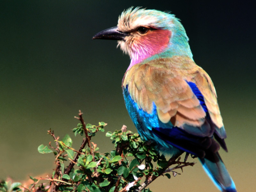

In [5]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Nice a lil' kingfisher.

Now let's use the functions we have setup to perform a search for "forest photos"

Searching for 'forest photos'


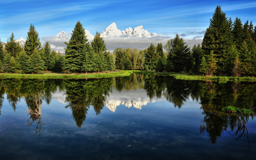

In [6]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Yep, that looks like a forest.

Our searches seem to be giving reasonable results, so let's grab a few examples each of "bird" and "forest" photos, and save each group of photos to a different folder.

We are going to modify each of the searches with two additional terms "sun" and "shade" to get a range of lighting conditions.

In [7]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


## Step 2: Train our model

If we check our storage in the sidebar we should be able to see that we have two folders filled with images. Time to get training.

Some photos might not download correctly which could cause our model training to fail, so we'll remove them

In [16]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

In [18]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.797813,0.691945,0.294118,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.093367,0.056029,0.000000,00:01
1,0.055306,0.056311,0.029412,00:00
2,0.048463,0.074720,0.029412,00:00


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [11]:
image = PILImage.create('bird.jpg')

is_bird,_,probs = learn.predict(image)
image.show()
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


Yep, that IS a bird! Good job resnet18.

That is it you have fine tuned your first model for a specfic task. From here feel free to duplicate the notebook and import your own data sets to try on.

Below I have included some additional functions to push the testing of the model to try and highlight the importance of good data.

We define a new function called "check_if_bird" that will accept a bunch of more specific search terms both bird and forest related to see how it performs.

In [12]:
import random

def check_if_bird(search_terms, model, max_images=30, dest='test_image.jpg'):
    term = random.choice(search_terms)
    urls = search_images(f'{term} photos', max_images=max_images)
    
    if urls:
        random_url = random.choice(urls)
        download_url(random_url, dest, show_progress=False)
        image = PILImage.create(dest)
        
        is_bird, _, probs = model.predict(image)
        image.show()
        
        print(f"Search term: {term}")
        print(f"This is a: {is_bird}.")
        print(f"Probability it's a bird: {probs[0]:.4f}")
    else:
        print("No image found for the given term.")

In [13]:
search_terms = ['Wedge-tailed', 'gouldian', 'bourkes parrot', 'jabiru', 'boobook', 
                'hardhead', 'great cormorant', 'gang-gang cockatoo', 'pardalote', 'starling',
                'Rainforest', 'Taiga', 'Savanna', 'Mangrove', 'Woodland', 
                'Boreal', 'Temperate', 'Tropical', 'Coniferous', 'Deciduous']

Run the following cell a few times and see how our very quick fine tuning fares.

Searching for 'Deciduous photos'


Search term: Deciduous
This is a: forest.
Probability it's a bird: 0.0006


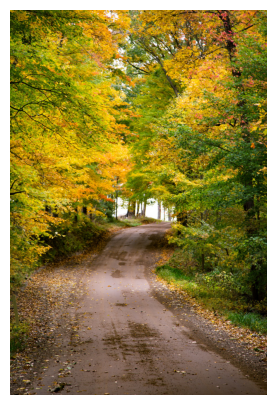

In [14]:
check_if_bird(search_terms, learn)

# Further reading

Practical deep learning for coders: https://course.fast.ai/